In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model # type: ignore
import joblib
from eodhd import APIClient
from datetime import datetime, timedelta
from datetime import datetime
API =  "6692ff520ca5b8.24552354" # eodhd

In [2]:
def get_data(stock: str = 'AAPL', symbol: str = 'US', period: str = 'd', from_date = None, to_date = None, day_before: int = 20, order='a'):
    current_date = datetime.now()
    formatted_current_date = current_date.strftime('%Y-%m-%d')
    date_10_days_before = current_date - timedelta(days=day_before)
    formatted_date_10_days_before = date_10_days_before.strftime('%Y-%m-%d')
    if from_date is None: from_date = formatted_date_10_days_before
    if to_date is None: to_date = formatted_current_date
    
    print(from_date, to_date)
    
    api = APIClient(API)

    resp = api.get_eod_historical_stock_market_data(symbol = f'{stock}.{symbol}', period=period, from_date = from_date, to_date = to_date, order=order)

    data_dict = {}

    for item in resp:
        data_dict[item.pop('date')] = item

    print(data_dict)
    return data_dict

def format_data(data:dict):
    df = pd.DataFrame.from_dict(data, orient='index')
    df.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    return df

In [3]:
model = load_model('lstm_model_test.keras', compile=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
scaler = joblib.load('scaler.gz')

In [4]:
data_dict = get_data(day_before=100, order='a')
df= format_data(data_dict)
df = df.iloc[-20:]
print(len(df), df)

2024-04-08 2024-07-17
{'2024-04-08': {'open': 169.03, 'high': 169.2, 'low': 168.24, 'close': 168.45, 'adjusted_close': 168.2218, 'volume': 37425500}, '2024-04-09': {'open': 168.7, 'high': 170.08, 'low': 168.35, 'close': 169.67, 'adjusted_close': 169.4402, 'volume': 42451200}, '2024-04-10': {'open': 168.8, 'high': 169.09, 'low': 167.11, 'close': 167.78, 'adjusted_close': 167.5527, 'volume': 49709300}, '2024-04-11': {'open': 168.34, 'high': 175.46, 'low': 168.16, 'close': 175.04, 'adjusted_close': 174.8029, 'volume': 91070300}, '2024-04-12': {'open': 174.26, 'high': 178.36, 'low': 174.21, 'close': 176.55, 'adjusted_close': 176.3109, 'volume': 101593300}, '2024-04-15': {'open': 175.36, 'high': 176.63, 'low': 172.5, 'close': 172.69, 'adjusted_close': 172.4561, 'volume': 73531800}, '2024-04-16': {'open': 171.75, 'high': 173.76, 'low': 168.27, 'close': 169.38, 'adjusted_close': 169.1506, 'volume': 73711200}, '2024-04-17': {'open': 169.61, 'high': 170.65, 'low': 168, 'close': 168, 'adjusted_c

In [5]:
def get_scaled_data(df, scaler: MinMaxScaler, target_column: str = 'Close'):
    target_column_index = df.columns.tolist().index(target_column)
    scaled_data = scaler.fit_transform(df)
    return scaled_data, target_column_index

In [6]:
scaled_data, target_column_index = get_scaled_data(df=df, scaler=scaler)

In [7]:
def create_dataset(data: np.ndarray, time_step: int=10):
    X = []
    for i in range(len(data) - time_step):
        # Define the range of input sequences
        end_ix = i + time_step
        
        # Ensure that the dataset is within bounds
        if end_ix > len(data)-1:
            break
            
        # Extract input and output parts of the pattern
        seq_x = data[i:end_ix]
        
        # Append the parts
        X.append(seq_x)
    return np.array(X), data.shape[1], time_step

X, feature_number, time_step = create_dataset(data=scaled_data)
print(len(X))
print(len(df))
print(X[:1])

10
20
[[[0.19645341 0.29284333 0.23132075 0.33589462 0.33589462 0.26959134]
  [0.34318498 0.28046422 0.24188679 0.24881083 0.24881083 0.20365068]
  [0.2159249  0.1106383  0.08528302 0.08013172 0.08013172 0.23344811]
  [0.09283727 0.01972921 0.01962264 0.         0.         1.        ]
  [0.         0.05106383 0.         0.02378339 0.02378339 0.20739951]
  [0.04972184 0.         0.07622642 0.05781193 0.05781193 0.09253266]
  [0.13143255 0.13462282 0.15283019 0.21075741 0.21075741 0.13797263]
  [0.24235049 0.16866538 0.21735849 0.24185876 0.24185876 0.05932937]
  [0.27990264 0.18143133 0.14       0.11452616 0.11452616 0.21608493]
  [0.15194715 0.23713733 0.20113208 0.33882181 0.33882181 0.11017902]]]


In [8]:
predicted_data = model.predict(X)
print(predicted_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
[[0.21608308]
 [0.29122055]
 [0.35195678]
 [0.45166647]
 [0.52322596]
 [0.57434475]
 [0.6663761 ]
 [0.630796  ]
 [0.6630873 ]
 [0.77753574]]


In [9]:
# Inverse transform the predictions
def update_data_to_inverse(predicted_data: np.ndarray, scaler: MinMaxScaler, target_column_index: int, feature_number: int):
    new_dataset = np.zeros(shape=(len(predicted_data), feature_number))
    new_dataset[:,target_column_index] = predicted_data.flatten()
    return scaler.inverse_transform(new_dataset)[:, target_column_index].reshape(-1, 1)

In [10]:
predicted_data = update_data_to_inverse(predicted_data=predicted_data, scaler=scaler, target_column_index=target_column_index, feature_number=feature_number)

In [11]:
new_df = df[['Close']].iloc[-10:].copy()
new_df['Predicted_close'] = predicted_data

next_day = df.index.max() + pd.DateOffset(days=1)
last_prediction = pd.DataFrame({'Close': [np.nan], 'Predicted_close': predicted_data[-1]}, index=[f"{next_day} 00:00:00"])
desired_prediction = np.full((11,1), np.nan)
new_df = pd.concat([new_df, last_prediction])
desired_prediction[-2] = new_df['Close'][-2]
desired_prediction[-1] = new_df['Predicted_close'][-1]
desired_prediction = desired_prediction.reshape(-1,1)
new_df['Desired_prediction'] = desired_prediction


# Ensure the index is in datetime format
new_df.index = pd.to_datetime(new_df.index)

# Convert the datetime index to 'day-month' format
new_df.index = new_df.index.strftime('%m-%d')

print(new_df)

#ORDER ??

             Close  Predicted_close  Desired_prediction
07-02 220.27000000     213.39555056                 NaN
07-03 221.55000000     215.44905752                 NaN
07-05 226.34000000     217.10897893                 NaN
07-08 227.82000000     219.83404474                 NaN
07-09 228.68000000     221.78976557                 NaN
07-10 232.98000000     223.18684213                 NaN
07-11 227.57000000     225.70205919                 NaN
07-12 230.54000000     224.72965510                 NaN
07-15 234.40000000     225.61217614                 NaN
07-16 234.82000000     228.74005168        234.82000000
07-17          NaN     228.74005168        228.74005168


C:\Users\orhun\AppData\Local\Temp\ipykernel_9004\3765866443.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  desired_prediction[-2] = new_df['Close'][-2]
C:\Users\orhun\AppData\Local\Temp\ipykernel_9004\3765866443.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  desired_prediction[-1] = new_df['Predicted_close'][-1]


In [16]:
df.to_csv(f'predictions.csv')

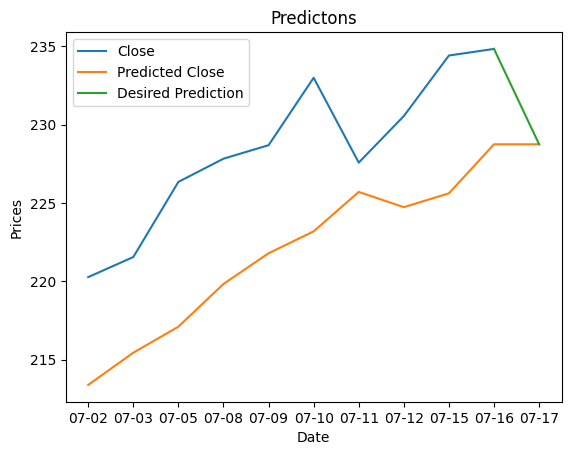

In [17]:
plt.plot(new_df['Close'], label='Close')
plt.plot(new_df['Predicted_close'], label='Predicted Close')
plt.plot(new_df['Desired_prediction'], label='Desired Prediction')
plt.title('Predictons')
plt.ylabel('Prices')
plt.xlabel('Date')
plt.legend()
plt.savefig('figure.png')